# Optimizers

*Author: Bjarne Hiller*

*Date: 20-10-2023*

**Objective**:

- Gain a better understanding of the different optimizer strategies!

**Methodology**:

- define a simple CNN model for the MNIST dataset
- compare the train loss for different optimizers
- reimplement the optimizers

# Loading the MNIST Dataset

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision

torch.manual_seed(19)

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
# download and load mnist datasets

data_path = "data/mnist/"
batch_size = 64

transform = Compose([
    ToTensor(),
    # global mean and standard deviation of the MNIST dataset
    Normalize((0.1307,), (0.3081,))
])

train_ds = MNIST(data_path, train=True, download=True, transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds =  MNIST(data_path, train=False, download=True, transform=transform)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

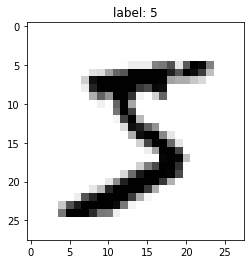

In [3]:
import matplotlib.pyplot as plt

# let's plot the first sample
x, y = train_ds[0]
plt.imshow(x.squeeze(), cmap="binary")
plt.title(f"label: {y}")
plt.show()

# Defining the Model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,5)
        self.conv2 = nn.Conv2d(16,16,5)
        self.linear1 = nn.Linear(256, 64)
        self.linear2 = nn.Linear(64, 10)

    def forward(self, x):
        # (batch, 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        # (batch, 16, 12, 12)
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, 2))
        # (batch, 16, 4, 4)
        x = x.view(-1, 256)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        # no relu on last layer: this are our predictions!
        return x

In [5]:
# quick check if the model works
model = CNN()
model(x.unsqueeze(0))

tensor([[-0.0669, -0.0022,  0.0134, -0.0720,  0.1956, -0.1237,  0.1112, -0.2671,
          0.0916, -0.1654]], grad_fn=<AddmmBackward0>)

In [6]:
from torchmetrics import Accuracy

def train(model, optimizer, dl):
    model.train()
    ls = []
    criterion = nn.CrossEntropyLoss()
    for X, y in dl:
        y_hat = model(X)
        loss = criterion(y_hat, y)
        ls.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return ls

@torch.no_grad()
def test(model, dl):
    model.eval()
    acc = Accuracy("multiclass", num_classes=10)
    for X, y in dl:
         y_hat = model(X)
         acc(y_hat, y)
    return acc.compute().item()

# Comparing Optimizers

In [7]:
import copy
from tqdm.notebook import trange, tqdm

epochs = 3
lr = 1e-3

model = CNN()
# need to deepcopy the state_dict to fully detach it from the model
init_state = copy.deepcopy(model.state_dict())

optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=lr),
    "AdaGrad": optim.Adagrad(model.parameters(), lr=lr),
    "RMSprop": optim.RMSprop(model.parameters(), lr=lr),
    "Adam": optim.Adam(model.parameters(), lr=lr),
}

ls = {}
for opt_name, optimizer in optimizers.items():
    print(f"OPTIMIZER: {opt_name}")
    # reset model
    model.load_state_dict(init_state)
    ls[opt_name] = []
    for epoch in trange(epochs):
        ls[opt_name] += train(model, optimizer, train_dl)
    acc = test(model, test_dl)
    print(f"test accuracy: {acc}")
    print("---" * 19)

OPTIMIZER: SGD


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.8766000270843506
---------------------------------------------------------
OPTIMIZER: AdaGrad


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.929099977016449
---------------------------------------------------------
OPTIMIZER: RMSprop


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.9887999892234802
---------------------------------------------------------
OPTIMIZER: Adam


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.9854999780654907
---------------------------------------------------------


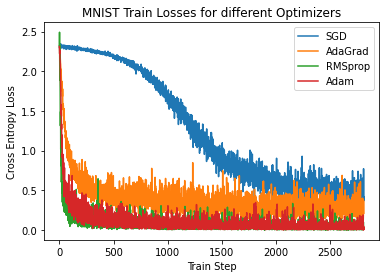

In [8]:
for opt_name, l in ls.items():
    plt.plot(l, label=opt_name)
plt.legend()
plt.title("MNIST Train Losses for different Optimizers")
plt.xlabel("Train Step")
plt.ylabel("Cross Entropy Loss")
plt.show()

# Re-Implementing the Optimizers

- see Ruder (2017): [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747.pdf)
- https://www.ruder.io/optimizing-gradient-descent/

In [9]:
class Optimizer:
    def __init__(self, params, lr=1e-4, momentum=0):
        # model.parameters() returns iterator, store as list
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    # disable gradient since we overwrite leaf variables
    @torch.no_grad()
    def step(self):
        raise NotImplementedError

## Stochastic Gradient Descent (SGD)

- plain Gradient Descent might become computationally infeasible for large datasets
- sample a subset of the whole dataset
- perform Gradient Descent on Subset

$\theta \leftarrow \theta - \alpha \nabla_\theta f(\theta)$

In [10]:
class SGD(Optimizer):
    # disable gradient since we overwrite a leaf variable
    @torch.no_grad()
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

## AdaGrad (**Ada**ptive **Grad**ients):

- Duchi et al. (2011): ["Adaptive Subgradient Methods for Online Learning and Stochastic Optimization"](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- often, high-dimensional data is sparse: only a few non-zero features in each sample
- infrequent features are usually highly informative, but associated parameters only receive occasional updates
- therefore, would need different learning rates for each feature
- AdaGrad regards geometry of the data
- low learning rate for frequent feature, high learning rate for rare features
- problem: initially large gradients can slow down updates for the remaining training
- problem: accumalation of all gradients can reduce updates too much

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, lr=1e-4, momentum=0, epsilon=1e-8):
        super().__init__(params, lr, momentum)
        self.G = [0] * len(self.params)
        self.epsilon = epsilon
    
    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            # add gradients 
            self.G[i] += param.grad * param.grad
            param -= self.lr * param.grad / (self.epsilon + torch.sqrt(self.G[i]))

## RMSprop (**R**oot **M**ean **S**quare **Prop**agation)

- unpublished improvement of AdaGrad [proposed 2012 by Geoffrey Hinton](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
- only norm updates by most recent gradients

In [12]:
class RMSprop(Optimizer):
    def __init__(self, params, lr=1e-4, momentum=0, epsilon=1e-8, alpha=0.99):
        super().__init__(params, lr, momentum)
        self.G = [0] * len(self.params)
        self.epsilon = epsilon
        self.alpha = alpha
    
    @torch.no_grad()
    def step(self):
        for i, param in enumerate(self.params):
            # let previously recorded gradients decay exponentially and add new gradients 
            self.G[i] = self.alpha * self.G[i] + (1 - self.alpha) * param.grad * param.grad
            param -= self.lr * param.grad / (self.epsilon + torch.sqrt(self.G[i]))

## Adam (**Ada**ptive **m**oment estimation):

- Kingma et al. (2017): [Adam: A Method for Stochastic Optimization](https://doi.org/10.48550/arXiv.1412.6980)
- combines advantages of AdaGrad and RMSprop
- estimates of 1st and 2nd momentum are initialized as 0 vectors
- therefore biased towards 0
- Adam performs bias correction
- robust regarding scaling of gradients
- implicit step size annealing
- newest upgrade: AdamW

In [13]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-4, momentum=0, epsilon=1e-8, betas=(0.9, 0.999)):
        super().__init__(params, lr, momentum)
        # this initialization with 0 is actually problematic
        # will cause the moment estimations to be biased towards 0
        self.m = [0] * len(self.params)
        self.v = [0] * len(self.params)
        # let's record the number of update steps
        # bias will become less relevant with more observations
        self.t = 0
        self.epsilon = epsilon
        self.betas = betas

    @torch.no_grad()
    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            # estimate of the first moment (mean)
            self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * param.grad
            # similar to RMSprop, here it is beta[1] instead of alpha
            # estimate of the second moment (centered variance)
            self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * param.grad * param.grad
            # initialization bias correction
            m_hat = self.m[i] / (1 - self.betas[0]**self.t)
            v_hat = self.v[i] / (1 - self.betas[1]**self.t)
            # add epsilon to avoid division by zero
            param -= self.lr * self.m[i] / (self.epsilon + torch.sqrt(self.v[i]))

In [14]:
optimizers2 = {
    "SDG": SGD(model.parameters(), lr=lr),
    "AdaGrad": AdaGrad(model.parameters(), lr=lr),
    "RMSprop": RMSprop(model.parameters(), lr=lr),
    "Adam": Adam(model.parameters(), lr=lr),
}

ls2 = {}
for opt_name, optimizer in optimizers2.items():
    print(f"OPTIMIZER: {opt_name}")
    # reset model
    model.load_state_dict(init_state)
    ls2[opt_name] = []
    for epoch in trange(epochs):
        ls2[opt_name] += train(model, optimizer, train_dl)
    acc = test(model, test_dl)
    print(f"test accuracy: {acc}")
    print("---" * 19)

OPTIMIZER: SDG


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.8741000294685364
---------------------------------------------------------
OPTIMIZER: AdaGrad


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.9312000274658203
---------------------------------------------------------
OPTIMIZER: RMSprop


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.9876999855041504
---------------------------------------------------------
OPTIMIZER: Adam


  0%|          | 0/3 [00:00<?, ?it/s]

test accuracy: 0.9876000285148621
---------------------------------------------------------


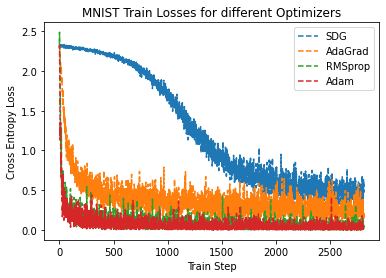

In [15]:
for opt_name, l in ls2.items():
    plt.plot(l, label=opt_name, linestyle="--")

plt.legend()
plt.title("MNIST Train Losses for different Optimizers")
plt.xlabel("Train Step")
plt.ylabel("Cross Entropy Loss")
plt.show()

# Learning Rate Scheduling

- by default, PyTorch does NOT automatically reduce the learning rate over time!
- the same learning rate is used over training
- if the learning rate is too big, the model might fail to learn anything at all
- if the learning rate is too small, the training might be over before the model achieves anything
- for complex training scenarios, use **Learning Rate Schedulers**
- see here for [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/common/optimization.html)

```python
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
```